# Data Mining 7331 - Fall 2019
## Lab 3 - Collaborative Filtering

* **Allen Ansari**
* **Chad Madding**
* **Yongjun (Ian) Chu**

## Introduction
Different tasks will require different evaluation methods. Be as thorough as possible when analyzing the data you have chosen and use visualizations of the results to explain the performance and expected outcomes whenever possible. Guide the reader through your analysis with plenty of discussion of the results.

### Table of Contents<a id="top"></a>
* **[Business Understanding](#Business_Understanding)**
    * **[10 points]** Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?
* **[Data Understanding - Description](#Data_Understanding_Description)**
    * **[10 points]** Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?
* **[Data Understanding - Visualization](#Data_Understanding_Visualization)**
    * **[10 points]** Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.
* **[Modeling and Evaluation - Train & Adjust Parameters](#Modeling_and_Evaluation_Train_and_adjust_parameters)**
    * **[10 points]** Create user-item matrices or item-item matrices using collaborative filtering.
* **[Modeling and Evaluation - Evaluate & Compare](#Modeling_and_Evaluation_Evaluate_and_Compare)**
    * **[10 points]** Determine performance of the recommendations using different performance measures and explain what each measure.
* **[Modeling and Evaluation - Visualize Results](#Modeling_and_Evaluation_Visualize_Results)**
    * **[10 points]** Use tables/visualization to discuss the found results. Explain each visualization in detail.
* **[Modeling and Evaluation - Summarize The Ramifications](#Modeling_and_Evaluation_Summarize_The_Ramifications)**
    * **[20 points]** Describe your results. What findings are the most interesting and why?
* **[Deployment](#Deployment)**
    * **[10 points]** Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?
        - How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?
        - How would your deploy your model for interested parties?
        - What other data should be collected?
        - How often would the model need to be updated, etc.?
* **[Exceptional Work](#Exceptional_Work)**
    * **[10 points]** You have free reign to provide additional analyses or combine analyses.

<a href="#top">Back to Top</a>
### Business Understanding<a id="Business Understanding"></a>
* Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

<a href="#top">Back to Top</a>
### Data Understanding - Description<a id="Data_Understanding_Description"></a>
* Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

This dataset (ml-20m) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 20000263 ratings and 465564 tag applications across 27278 movies. These data were created by 138493 users between January 09, 1995 and March 31, 2015. This dataset was generated on March 31, 2015, and updated on October 17, 2016 to update links.csv and add genome-* files.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in six files, `genome-scores.csv`, `genome-tags.csv`, `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`. More details about the contents and use of all these files follows.

This and other GroupLens data sets are publicly available for download at <http://grouplens.org/datasets/>.

Formatting and Encoding
-----------------------
The dataset files are written as [comma-separated values](http://en.wikipedia.org/wiki/Comma-separated_values) files with a single header row. Columns that contain commas (`,`) are escaped using double-quotes (`"`). These files are encoded as UTF-8. If accented characters in movie titles or tag values (e.g. Misérables, Les (1995)) display incorrectly, make sure that any program reading the data, such as a text editor, terminal, or script, is configured for UTF-8.

### Imports Of Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import spatial

#enable inline plotting
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import re
import os

### Imports Of Data

In [2]:
print(os.listdir("ml-20m"))

genomescores = pd.read_csv("ml-20m/genome-scores.csv")
genometags = pd.read_csv("ml-20m/genome-tags.csv")
links = pd.read_csv("ml-20m/links.csv")
movies = pd.read_csv("ml-20m/movies.csv")
ratings = pd.read_csv("ml-20m/ratings.csv")
tags = pd.read_csv("ml-20m/tags.csv")

['genome-scores.csv', 'genome-tags.csv', 'links.csv', 'movies.csv', 'ratings.csv', 'README.txt', 'tags.csv']


Movie Ids
---------
Only movies with at least one rating or tag are included in the dataset. These movie ids are consistent with those used on the MovieLens web site (e.g., id `1` corresponds to the URL <https://movielens.org/movies/1>). Movie ids are consistent between `ratings.csv`, `tags.csv`, `movies.csv`, and `links.csv` (i.e., the same id refers to the same movie across these four data files).

User Ids
--------
MovieLens users were selected at random for inclusion. Their ids have been anonymized. User ids are consistent between `ratings.csv` and `tags.csv` (i.e., the same id refers to the same user across the two files).

Tag Genome (genome-scores.csv and genome-tags.csv)
-------------------------------------------------
This data set includes a current copy of the Tag Genome.

[genome-paper]: http://files.grouplens.org/papers/tag_genome.pdf

The tag genome is a data structure that contains tag relevance scores for movies.  The structure is a dense matrix: each movie in the genome has a value for *every* tag in the genome.

As described in [this article][genome-paper], the tag genome encodes how strongly movies exhibit particular properties represented by tags (atmospheric, thought-provoking, realistic, etc.). The tag genome was computed using a machine learning algorithm on user-contributed content including tags, ratings, and textual reviews.

The genome is split into two files.  The file `genome-scores.csv` contains movie-tag relevance data in the following format:

    movieId,tagId,relevance

The second file, `genome-tags.csv`, provides the tag descriptions for the tag IDs in the genome file, in the following format:

    tagId,tag

The `tagId` values are generated when the data set is exported, so they may vary from version to version of the MovieLens data sets.

In [3]:
# Show the dimension and the first 5 rows of the dataset
print(genomescores.shape)
print(type(genomescores))
genomescores.head(5)

(11709768, 3)
<class 'pandas.core.frame.DataFrame'>


movieId  tagId  relevance
0        1      1    0.02500
1        1      2    0.02500
2        1      3    0.05775
3        1      4    0.09675
4        1      5    0.14675

In [4]:
# Show the dimension and the first 5 rows of the dataset
print(genometags.shape)
genometags.head(5)

(1128, 2)


tagId           tag
0      1           007
1      2  007 (series)
2      3  18th century
3      4         1920s
4      5         1930s

Links Data File Structure (links.csv)
---------------------------------------
Identifiers that can be used to link to other sources of movie data are contained in the file `links.csv`. Each line of this file after the header row represents one movie, and has the following format:

    movieId,imdbId,tmdbId

movieId is an identifier for movies used by <https://movielens.org>. E.g., the movie Toy Story has the link <https://movielens.org/movies/1>.

imdbId is an identifier for movies used by <http://www.imdb.com>. E.g., the movie Toy Story has the link <http://www.imdb.com/title/tt0114709/>.

tmdbId is an identifier for movies used by <https://www.themoviedb.org>. E.g., the movie Toy Story has the link <https://www.themoviedb.org/movie/862>.

Use of the resources listed above is subject to the terms of each provider.

In [5]:
# Show the dimension and the first 5 rows of the dataset
print(links.shape)
links.head(5)

(27278, 3)


movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0

Movies Data File Structure (movies.csv)
---------------------------------------
Movie information is contained in the file `movies.csv`. Each line of this file after the header row represents one movie, and has the following format:

    movieId,title,genres

Movie titles are entered manually or imported from <https://www.themoviedb.org/>, and include the year of release in parentheses. Errors and inconsistencies may exist in these titles.

Genres are a pipe-separated list, and are selected from the following:

* Action
* Adventure
* Animation
* Children's
* Comedy
* Crime
* Documentary
* Drama
* Fantasy
* Film-Noir
* Horror
* Musical
* Mystery
* Romance
* Sci-Fi
* Thriller
* War
* Western
* (no genres listed)

In [6]:
# Show the dimension and the first 5 rows of the dataset
print(movies.shape)
movies.head(5)

(27278, 3)


movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

Ratings Data File Structure (ratings.csv)
-----------------------------------------
All ratings are contained in the file `ratings.csv`. Each line of this file after the header row represents one rating of one movie by one user, and has the following format:

    userId,movieId,rating,timestamp

The lines within this file are ordered first by userId, then, within user, by movieId.

Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).

Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

In [7]:
# Show the dimension and the first 5 rows of the dataset
print(ratings.shape)
ratings.head(5)

(20000263, 4)


userId  movieId  rating   timestamp
0       1        2     3.5  1112486027
1       1       29     3.5  1112484676
2       1       32     3.5  1112484819
3       1       47     3.5  1112484727
4       1       50     3.5  1112484580

Tags Data File Structure (tags.csv)
-----------------------------------
All tags are contained in the file `tags.csv`. Each line of this file after the header row represents one tag applied to one movie by one user, and has the following format:

    userId,movieId,tag,timestamp

The lines within this file are ordered first by userId, then, within user, by movieId.

Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag is determined by each user.

Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

In [8]:
# Show the dimension and the first 5 rows of the dataset
print(tags.shape)
tags.head(5)

(465564, 4)


userId  movieId            tag   timestamp
0      18     4141    Mark Waters  1240597180
1      65      208      dark hero  1368150078
2      65      353      dark hero  1368150079
3      65      521  noir thriller  1368149983
4      65      592      dark hero  1368150078

## Merge Movies, Tags and Ratings Dataframes into mergedDF

##### Remove the timestamp data and create a year column

In [9]:
#for this lab we will not be using the timestamp data
del ratings['timestamp']
del tags['timestamp']

#create year column
movies['year'] = movies['title'].str.extract('.*\((.*)\).*', expand=True)
movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  year  
0  Adventure|Animation|Children|Comedy|Fantasy  1995  
1                   Adventure|Children|Fantasy  1995  
2                               Comedy|Romance  1995  
3                         Comedy|Drama|Romance  1995  
4                                       Comedy  1995

##### Merge movies with tags to get a more full dataset

In [10]:
#merge movies with tags to get a more full dataset
movies_tag = movies.merge(tags, on='movieId', how='inner')
movies_tag.head()

movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   year  userId                                     tag  
0  1995    1644                                 Watched  
1  1995    1741                      computer animation  
2  1995    1741                 Disney animated feature  
3  1995    1741                         Pixar animation  
4  1995    1741  TÃ©a Leoni does not star in this movie

In [11]:
# then merge movies_tag and rating data
mergedDF = pd.merge(movies_tag,ratings)
# now lets look at our data
mergedDF.head(10)

movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
5        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
6        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
7        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
8        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
9        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   year  userId                                     tag  rating  
0  1995    1644                                 Watched     3.5  
1  1995    1741                      computer animation     4.0  
2  1995    1741                 Disney animated feature     4.0  
3  1995    1741                         Pixar animation     4.0  
4  1995    1741  TÃ©a Leoni does not star in this movie     4.0  
5  1995    2299                                   Pixar     3.0  
6  1995    3596                               animation     1.0  
7  1995    3596                                  family     1.0  
8  1995    3596                               Tom Hanks     1.0  
9  1995    6233                                   Pixar     4.5

In [12]:
#count the number of movies in each genres
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue
        for s in liste_keywords: 
            if pd.notnull(s): keyword_count[s] += 1
    # convert the dictionary in a list to sort the keywords  by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [13]:
#here we  make census of the genres
genre_labels = set()
for s in mergedDF['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

In [14]:
#counting how many times each of genres occur:
keyword_occurences, dum = count_word(mergedDF, 'genres', genre_labels)
keyword_occurences

[['Drama', 200635],
 ['Comedy', 118912],
 ['Thriller', 115062],
 ['Action', 107325],
 ['Sci-Fi', 78375],
 ['Adventure', 77199],
 ['Romance', 68338],
 ['Crime', 68294],
 ['Fantasy', 46217],
 ['Mystery', 42494],
 ['Horror', 36259],
 ['IMAX', 24988],
 ['Animation', 23644],
 ['Children', 20552],
 ['War', 19584],
 ['Musical', 13097],
 ['Documentary', 9032],
 ['Film-Noir', 5888],
 ['Western', 5607],
 ['(no genres listed)', 46]]

In [15]:
# Now make a column for every genre
# this will be a 1 or 0
mergedDF = mergedDF
for (key,cnt) in keyword_occurences:
    mergedDF.loc[mergedDF['genres'].str.contains(key), key] = 1
    mergedDF[key] = mergedDF[key].fillna(0)
mergedDF.head()

movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   year  userId                                     tag  rating  Drama  \
0  1995    1644                                 Watched     3.5    0.0   
1  1995    1741                      computer animation     4.0    0.0   
2  1995    1741                 Disney animated feature     4.0    0.0   
3  1995    1741                         Pixar animation     4.0    0.0   
4  1995    1741  TÃ©a Leoni does not star in this movie     4.0    0.0   

   Comedy  Thriller  ...  Horror  IMAX  Animation  Children  War  Musical  \
0     1.0       0.0  ...     0.0   0.0        1.0       1.0  0.0      0.0   
1     1.0       0.0  ...     0.0   0.0        1.0       1.0  0.0      0.0   
2     1.0       0.0  ...     0.0   0.0        1.0       1.0  0.0      0.0   
3     1.0       0.0  ...     0.0   0.0        1.0       1.0  0.0      0.0   
4     1.0       0.0  ...     0.0   0.0        1.0       1.0  0.0      0.0   

   Documentary  Film-Noir  Western  (no genres listed)  
0          0.0        0.0      0.0                 0.0  
1          0.0        0.0      0.0                 0.0  
2          0.0        0.0      0.0                 0.0  
3          0.0        0.0      0.0                 0.0  
4          0.0        0.0      0.0                 0.0  

[5 rows x 27 columns]

### Create a Pandas Profiling Report For The MovieLens Data Set

In [16]:
#Import Pandas Profiling for the report
#https://pypi.org/project/pandas-profiling/
import pandas_profiling
#To display the Pandas Profiling Report
# to install run:
# pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
mergedDF.profile_report(title='Pandas Profiling Report For The MovieLens Data Set',style={'full_width':True})

<a href="#top">Back to Top</a>
### Data Understanding - Visualization<a id="Data_Understanding_Visualization"></a>
* Visualize any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000170396F6940>]],
      dtype=object)

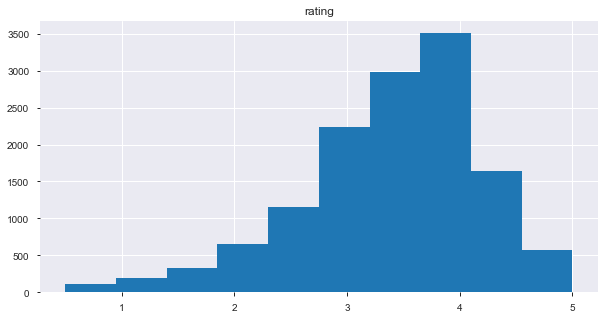

In [17]:
#looking at the rating averages
avg_ratings= mergedDF.groupby('movieId', as_index=False).mean()
del avg_ratings['userId']
del avg_ratings['Drama']
del avg_ratings['Comedy']
del avg_ratings['Thriller']
del avg_ratings['Action']
del avg_ratings['Sci-Fi']
del avg_ratings['Adventure']
del avg_ratings['Romance']
del avg_ratings['Crime']
del avg_ratings['Fantasy']
del avg_ratings['Mystery']
del avg_ratings['Horror']
del avg_ratings['IMAX']
del avg_ratings['Animation']
del avg_ratings['Children']
del avg_ratings['War']
del avg_ratings['Musical']
del avg_ratings['Documentary']
del avg_ratings['Film-Noir']
del avg_ratings['Western']
del avg_ratings['(no_genres_listed)']
avg_ratings.hist(column='rating', figsize=(10,5))

In [18]:
avg_ratings.head()

movieId    rating
0        1  3.908333
1        2  3.562500
2        3  2.928571
3        4  2.800000
4        5  2.761905

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000170397076D8>]],
      dtype=object)

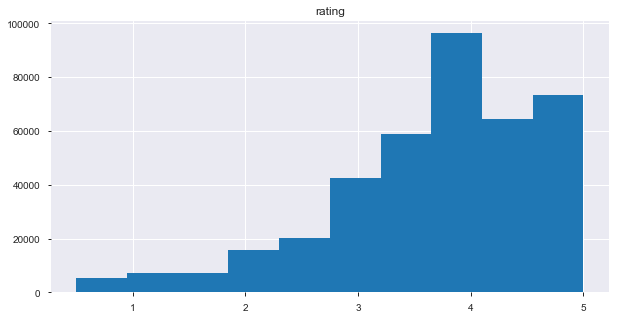

In [19]:
#looking at the distribution of the ratings
mergedDF.hist(column='rating', figsize=(10,5))

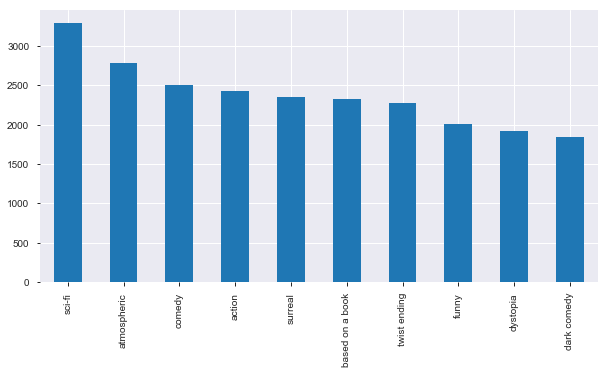

In [20]:
#looking at the top 10 tags
tag_counts = mergedDF['tag'].value_counts()
tag_counts[:10].plot(kind='bar', figsize=(10,5))

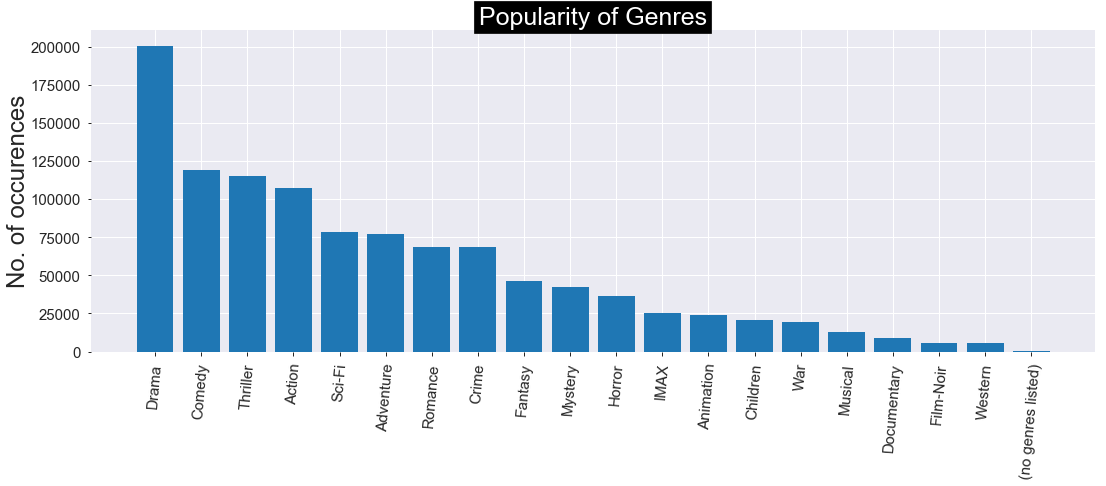

In [21]:
#Graph the Genres vs Occurrences
#https://github.com/nareshkumar66675/MovieLens/blob/master/notebooks/MovieLens.ipynb
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in keyword_occurences]
x_axis = [k for k,i in enumerate(keyword_occurences)]
x_label = [i[0] for i in keyword_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("No. of occurences", fontsize = 24, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center')
plt.title("Popularity of Genres",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 25)
plt.show()

<a href="#top">Back to Top</a>
### Modeling and Evaluation - Train & Adjust Parameters<a id="Modeling_and_Evaluation_Train_and_adjust_parameters"></a>
* Perform cluster analysis using several clustering methods (adjust parameters).

<a href="#top">Back to Top</a>
### Modeling and Evaluation - Evaluate & Compare<a id="Modeling_and_Evaluation_Evaluate_and_Compare"></a>
* Use internal and/or external validation measures to describe and compare the clusterings and the clusters — how did you determine a suitable number of clusters for each method?

<a href="#top">Back to Top</a>
### Modeling and Evaluation - Visualize Results<a id="Modeling_and_Evaluation_Visualize_Results"></a>
* Use tables/visualization to discuss the found results. Explain each visualization in detail.

<a href="#top">Back to Top</a>
### Modeling and Evaluation - Summarize The Ramifications<a id="Modeling_and_Evaluation_Summarize_The_Ramifications"></a>
* Describe your results. What findings are the most interesting and why?

<a href="#top">Back to Top</a>
### Deployment<a id="Deployment"></a>
* Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?
    - How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?
    - How would your deploy your model for interested parties?
    - What other data should be collected?
    - How often would the model need to be updated, etc.?

<a href="#top">Back to Top</a>
### Exceptional Work<a id="Exceptional_Work"></a>
* You have free reign to provide additional analyses or combine analyses.